In [19]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas_ta as ta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from backtesting import Backtest, Strategy
from backtesting.test import SMA


tickerList = [
    "aapl.us",
    "amzn.us",
    "googl.us",
    "msft.us",
    "tsla.us",
]  # list of stocks to analyze

# Dataset Prep

In [20]:
# load data
l = []

for ticker in tickerList:
    l.append(pd.read_csv(f"stocks/{ticker}.csv", header=0))
    l[-1].set_index("Date", inplace=True)

df = pd.concat(l, keys=tickerList, axis=0)

#data cleaning
condition = df.index.map(lambda index: pd.isna(index[1]))
df.drop(df.index[condition], inplace=True)  

df.dropna(subset=["Volume", "High", "Low"], inplace=True) 

df["Open"] = df["Open"].fillna(df["Close"].shift(1)) 

df["Close"] = df["Close"].fillna(df["Open"].shift(-1)) 

df.dropna(subset=["Open", "Close"], inplace=True) 

df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1], errors="coerce"), level=1)
df.sort_index(inplace=True)  

currDate = min([df.loc[i].index[-1] for i in tickerList])
lastDate = currDate - pd.tseries.offsets.DateOffset(years=10)

condition = df.index.map(lambda index: index[1].year < lastDate.year)
df.drop(df.index[condition], inplace=True)

In [21]:
# adding new columns

df["Daily Return"] = df.groupby(level=0, as_index=False, group_keys=False).apply(
    lambda x: ((x["Close"] / x["Close"].shift(1)) - 1) * 100
)

df["7-Day Moving Average"] = df.groupby(
    level=0, as_index=False, group_keys=False
).apply(lambda x: x.rolling(7)["Close"].mean())

df["30-Day Moving Average"] = df.groupby(
    level=0, as_index=False, group_keys=False
).apply(lambda x: x.rolling(30)["Close"].mean())

df["Rolling Volatility (30d)"] = df.groupby(
    level=0, as_index=False, group_keys=False
).apply(lambda x: x.rolling(30, min_periods=4)["Daily Return"].std())

df["RSI"] = df.groupby(level=0, as_index=False, group_keys=False).apply(
    lambda x: x.ta.rsi(close="Close", length=14)
)

In [22]:
df

Open     High      Low    Close     Volume  OpenInt  \
        Date                                                                 
aapl.us 2007-01-03   11.049   11.087   10.486   10.731  345302870        0   
        2007-01-04   10.780   11.007   10.733   10.969  236252357        0   
        2007-01-05   10.992   11.038   10.807   10.893  232773093        0   
        2007-01-08   11.011   11.081   10.922   10.946  222149027        0   
        2007-01-09   11.075   11.907   10.906   11.854  933759387        0   
...                     ...      ...      ...      ...        ...      ...   
tsla.us 2017-11-06  307.000  307.500  299.010  302.780    6482486        0   
        2017-11-07  301.020  306.500  300.030  306.050    5286320        0   
        2017-11-08  305.500  306.890  301.300  304.310    4725510        0   
        2017-11-09  302.500  304.460  296.300  302.990    5440335        0   
        2017-11-10  302.500  308.360  301.850  302.990    4621912        0   

                    Daily Return  7-Day Moving Average  30-Day Moving Average  \
        Date                                                                    
aapl.us 2007-01-03           NaN                   NaN                    NaN   
        2007-01-04      2.217873                   NaN                    NaN   
        2007-01-05     -0.692862                   NaN                    NaN   
        2007-01-08      0.486551                   NaN                    NaN   
        2007-01-09      8.295268                   NaN                    NaN   
...                          ...                   ...                    ...   
tsla.us 2017-11-06     -1.081381            314.527143             339.294800   
        2017-11-07      1.079992            312.410000             337.988133   
        2017-11-08     -0.568535            310.157143             336.766133   
        2017-11-09     -0.433768            306.080000             335.545800   
        2017-11-10      0.000000            303.495714             334.278133   

                    Rolling Volatility (30d)        RSI  
        Date                                             
aapl.us 2007-01-03                       NaN        NaN  
        2007-01-04                       NaN        NaN  
        2007-01-05                       NaN        NaN  
        2007-01-08                       NaN        NaN  
        2007-01-09                  3.995394        NaN  
...                                      ...        ...  
tsla.us 2017-11-06                  2.216589  31.849767  
        2017-11-07                  2.231713  34.374164  
        2017-11-08                  2.226119  33.659690  
        2017-11-09                  2.226150  33.097658  
        2017-11-10                  2.222447  33.097658  

[12802 rows x 11 columns]

# Define Funs and Vars

In [23]:
dfStock = pd.DataFrame(df.loc["amzn.us"])  # choose amzn stock
dfStock.reset_index(inplace=True)

dfStock

,Date,Open,High,Low,Close,Volume,OpenInt,Daily Return,7-Day Moving Average,30-Day Moving Average,Rolling Volatility (30d),RSI
0,2007-01-03,38.55,39.06,38.05,38.70,12401421,0,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,38.69,39.14,38.26,38.90,6318407,0,0.516796,NaN,NaN,NaN,NaN
2,2007-01-05,38.78,38.79,37.60,38.37,6619720,0,-1.362468,NaN,NaN,NaN,NaN
3,2007-01-08,38.22,38.31,37.17,37.50,6716623,0,-2.267396,NaN,NaN,NaN,NaN
4,2007-01-09,37.60,38.06,37.34,37.78,5702851,0,0.746667,NaN,NaN,1.463105,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,0.815041,1106.748571,1008.438333,2.510454,75.958310
2732,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,0.223975,1109.922857,1014.590667,2.507689,76.304545
2733,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,0.864517,1113.070000,1020.657667,2.504857,77.645752
2734,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0,-0.331015,1116.477143,1026.415333,2.510795,75.859923


In [24]:
def plotValues(y_test, y_pred, x=None):
    if x == None:
        x = list(range(len(y_test)))
    #plot ypred, ytrue and both in the same graph
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.delaxes(axs[1, 1])
    axs[0, 0].plot(x, y_test)
    axs[0, 0].set_title("y test")
    axs[0, 1].plot(x, y_pred)
    axs[0, 1].set_title("y pred")
    axs[1, 0].plot(x, y_pred, label="pred")
    axs[1, 0].plot(x, y_test, label="true")
    axs[1, 0].set_title("together")
    axs[1, 0].legend()
    plt.show()

In [25]:
def prediction_direction_accuracy(y_true, y_pred):
    y_trueNP = np.array(y_true)
    y_trueSign = np.diff(
        y_trueNP
    )  # get the change in closing prices -- then see their sign to sense the direction

    y_predNP = np.array(y_pred)
    y_predNP = np.delete(
        y_predNP, 0
    )  # delete the first elemnt and a random elemnt at the end
    y_predNP = np.append(y_predNP, [0])

    y_predSign = y_predNP - y_trueNP  # to then get the predicted directions
    y_predSign = np.delete(y_predSign, -1)  #to maintain consistent data length

    correctPred = np.sum(np.sign(y_trueSign) == np.sign(y_predSign))
    totalPred = len(y_trueSign)
    return correctPred / totalPred if totalPred > 0 else 0

# Linear Regression Model

MAE: 8.13436632888359
Direction Accuracy: 0.554945054945055


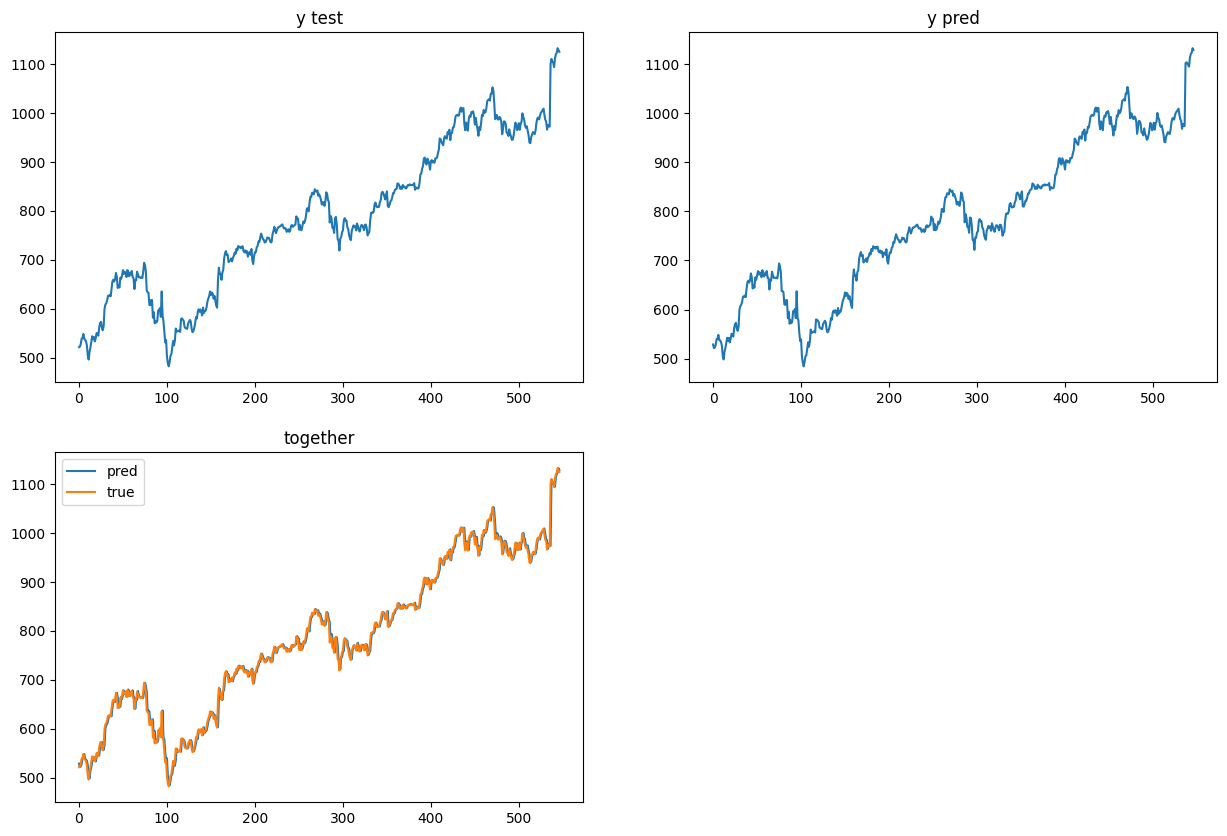

,Date,Open,High,Low,Close,Volume,OpenInt,Daily Return,7-Day Moving Average,30-Day Moving Average,Rolling Volatility (30d),RSI,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
5,2007-01-10,37.49,37.70,37.07,37.15,6527590,0,-1.667549,NaN,NaN,1.355375,NaN,37.78,37.50,38.37,38.90,38.70
6,2007-01-11,37.20,38.00,37.17,37.40,6465519,0,0.672948,37.971429,NaN,1.354463,NaN,37.15,37.78,37.50,38.37,38.90
7,2007-01-12,37.45,38.21,37.27,38.20,4466384,0,2.139037,37.900000,NaN,1.603004,NaN,37.40,37.15,37.78,37.50,38.37
8,2007-01-16,38.00,38.89,37.97,38.66,5637934,0,1.204188,37.865714,NaN,1.562099,NaN,38.20,37.40,37.15,37.78,37.50
9,2007-01-17,38.77,39.00,37.78,37.88,5023137,0,-2.017589,37.795714,NaN,1.608240,NaN,38.66,38.20,37.40,37.15,37.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,0.815041,1106.748571,1008.438333,2.510454,75.958310,1111.60,1094.22,1103.68,1105.28,1110.85
2732,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,0.223975,1109.922857,1014.590667,2.507689,76.304545,1120.66,1111.60,1094.22,1103.68,1105.28
2733,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,0.864517,1113.070000,1020.657667,2.504857,77.645752,1123.17,1120.66,1111.60,1094.22,1103.68
2734,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0,-0.331015,1116.477143,1026.415333,2.510795,75.859923,1132.88,1123.17,1120.66,1111.60,1094.22


In [26]:
df1=pd.DataFrame(dfStock)

#get prev 5 days closing
for lag in range(1, 6):
    df1[f"Close_lag_{lag}"] = df1["Close"].shift(lag)

features = [f"Close_lag_{lag}" for lag in range(1, 6)]
target = "Close"

#data cleaning
df1.dropna(subset=features, inplace=True)

#get features and traget dataframes
X = df1[features]
y = df1[target]

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#apply regression
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {lr_mae}')

lr_da = prediction_direction_accuracy(y_test, y_pred)
print(f'Direction Accuracy: {lr_da}')

plotValues(y_test, y_pred, None)

#define vars for further use in backtesting
lr_y_pred=pd.DataFrame(y_pred)
lr_y_true=pd.DataFrame(y_test)
lr_test=pd.DataFrame(df1)

df1

# Random Forest Regression Model

MAE: 263.8968638376383
Direction Accuracy: 0.4565619223659889


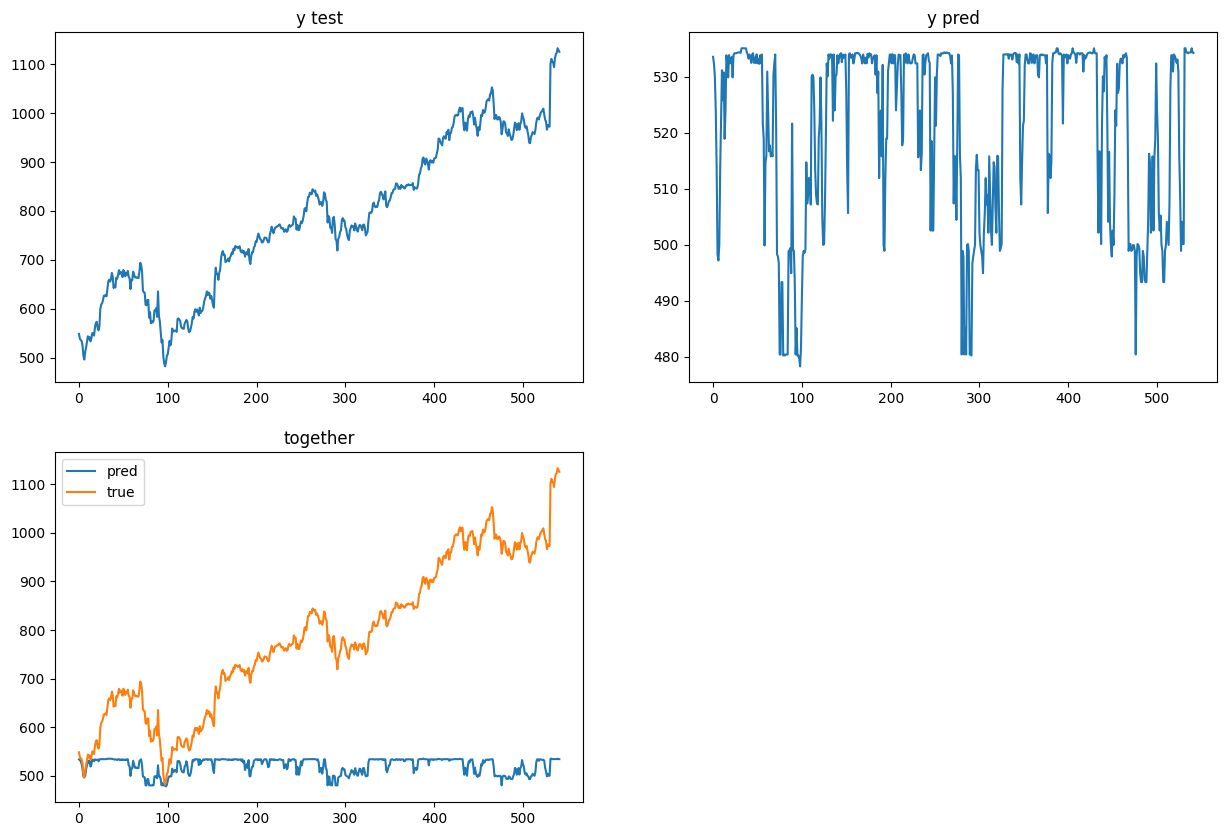

,Date,Open,High,Low,Close,Volume,OpenInt,Daily Return,7-Day Moving Average,30-Day Moving Average,Rolling Volatility (30d),RSI
29,2007-02-14,39.34,40.28,39.14,40.14,6814185,0,2.111422,39.052857,37.929333,1.680409,64.900934
30,2007-02-15,39.98,40.32,39.86,40.06,5088285,0,-0.199302,39.308571,37.974667,1.652342,64.081842
31,2007-02-16,39.90,40.44,39.87,40.33,4678927,0,0.673989,39.501429,38.022333,1.653865,65.657189
32,2007-02-20,40.13,41.74,40.00,41.51,8903334,0,2.925862,39.845714,38.127000,1.704639,71.533437
33,2007-02-21,41.18,41.32,40.92,41.26,4508315,0,-0.602265,40.208571,38.252333,1.645015,68.845717
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,0.815041,1106.748571,1008.438333,2.510454,75.958310
2732,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,0.223975,1109.922857,1014.590667,2.507689,76.304545
2733,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,0.864517,1113.070000,1020.657667,2.504857,77.645752
2734,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0,-0.331015,1116.477143,1026.415333,2.510795,75.859923


In [27]:
df1=pd.DataFrame(dfStock)

features = ["7-Day Moving Average", "30-Day Moving Average", "RSI"]
target = "Close"

df1.dropna(subset=features, inplace=True)

X = df1[features]
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

fr_mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {fr_mae}')

fr_da = prediction_direction_accuracy(y_test, y_pred)
print(f'Direction Accuracy: {fr_da}')

plotValues(y_test, y_pred, None)

df1

# ARIMA Model

In [28]:
df1 = pd.DataFrame(dfStock)

# check for staiornary data (p shd be less than 0.05)
adf_test = adfuller(df1["Close"])
print("ADF Statistic: %f" % adf_test[0])
print("p-value: %f" % adf_test[1])

ADF Statistic: 2.649446
p-value: 0.999083


In [29]:
#differnece the data for making it stationary 
df1["Diff Close"] = df1["Close"].diff()
df1.dropna(subset=["Diff Close"],inplace=True)

df1.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Daily Return,7-Day Moving Average,30-Day Moving Average,Rolling Volatility (30d),RSI,Diff Close
1,2007-01-04,38.69,39.14,38.26,38.90,6318407,0,0.516796,NaN,NaN,NaN,NaN,0.20
2,2007-01-05,38.78,38.79,37.60,38.37,6619720,0,-1.362468,NaN,NaN,NaN,NaN,-0.53
3,2007-01-08,38.22,38.31,37.17,37.50,6716623,0,-2.267396,NaN,NaN,NaN,NaN,-0.87
4,2007-01-09,37.60,38.06,37.34,37.78,5702851,0,0.746667,NaN,NaN,1.463105,NaN,0.28
5,2007-01-10,37.49,37.70,37.07,37.15,6527590,0,-1.667549,NaN,NaN,1.355375,NaN,-0.63


In [30]:
#ensure that data is prepared by checking p value
adf_test = adfuller(df1["Diff Close"])
print("ADF Statistic: %f" % adf_test[0])
print("p-value: %f" % adf_test[1])

ADF Statistic: -9.331776
p-value: 0.000000


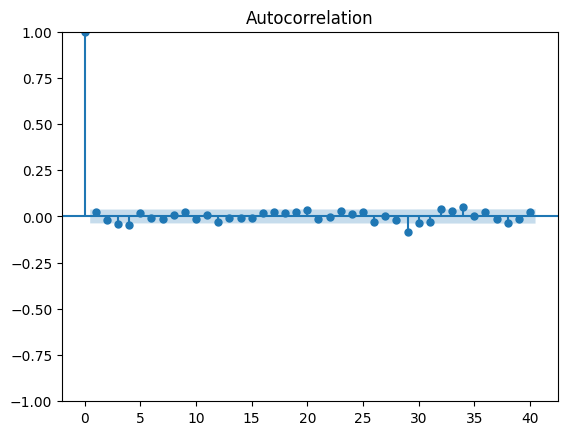

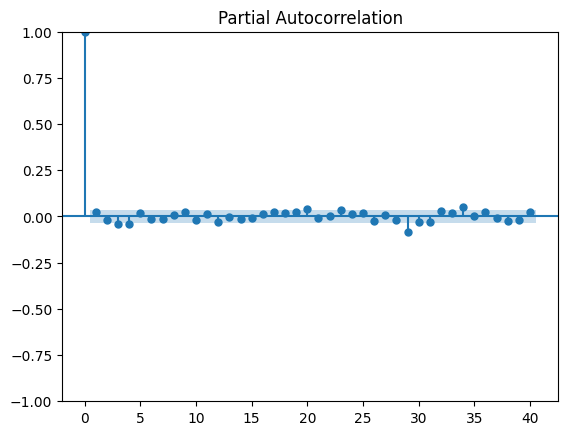

In [31]:
# get plots
plot_acf(df1["Diff Close"], lags=40)    #to get idea about the MA value
plot_pacf(df1["Diff Close"], lags=40)   #to get idea about the AR value
plt.show()

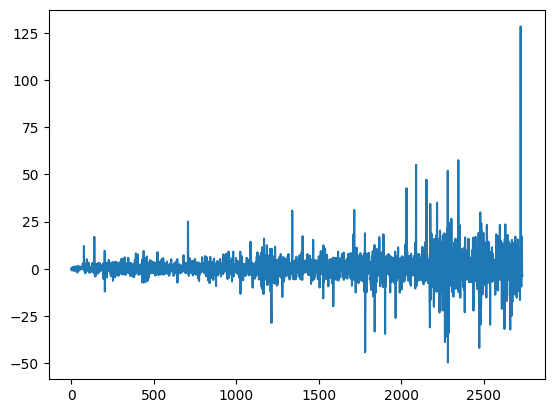

In [32]:
plt.plot(df1["Diff Close"])
plt.show()

MAE: 203.3182835876333
Direction Accuracy: 0.45787545787545786


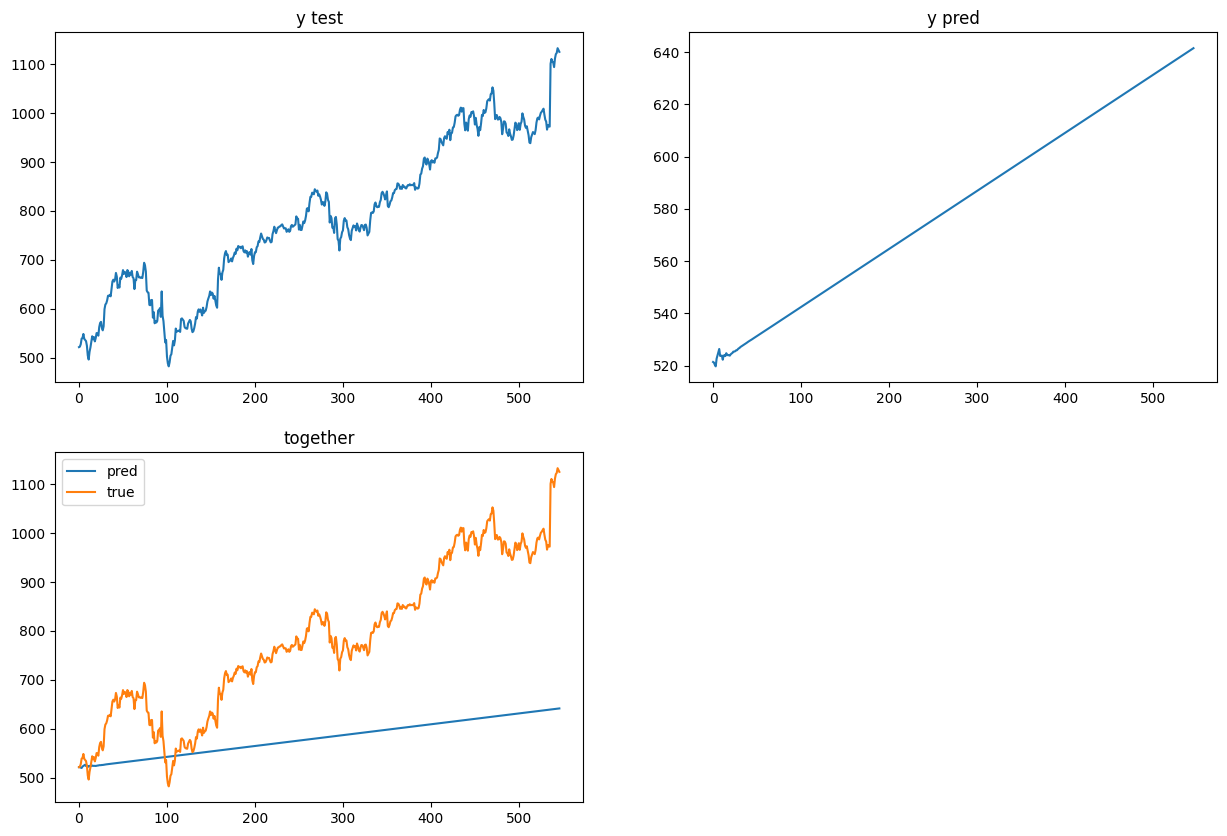

,Date,Open,High,Low,Close,Volume,OpenInt,Daily Return,7-Day Moving Average,30-Day Moving Average,Rolling Volatility (30d),RSI,Diff Close
1,2007-01-04,38.69,39.14,38.26,38.90,6318407,0,0.516796,NaN,NaN,NaN,NaN,0.20
2,2007-01-05,38.78,38.79,37.60,38.37,6619720,0,-1.362468,NaN,NaN,NaN,NaN,-0.53
3,2007-01-08,38.22,38.31,37.17,37.50,6716623,0,-2.267396,NaN,NaN,NaN,NaN,-0.87
4,2007-01-09,37.60,38.06,37.34,37.78,5702851,0,0.746667,NaN,NaN,1.463105,NaN,0.28
5,2007-01-10,37.49,37.70,37.07,37.15,6527590,0,-1.667549,NaN,NaN,1.355375,NaN,-0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,0.815041,1106.748571,1008.438333,2.510454,75.958310,9.06
2732,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,0.223975,1109.922857,1014.590667,2.507689,76.304545,2.51
2733,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,0.864517,1113.070000,1020.657667,2.504857,77.645752,9.71
2734,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0,-0.331015,1116.477143,1026.415333,2.510795,75.859923,-3.75


In [33]:
# split into test and train datasets
train_size = int(len(df1) * 0.8)
train, test = df1.iloc[0:train_size], df1.iloc[train_size : len(df1)]

# define arima model
model = ARIMA(df1.iloc[: len(train) + 1]["Diff Close"], order=(20, 0, 1))
model.initialize_approximate_diffuse()

model_fit = model.fit()

# predict values for test dataset
pred = model_fit.predict(start=test.index[0], end=test.index[-1], typ="levels")

test["Pred"] = pred

# get predicted clsoing prices (kind of inverse of the difference that we did to make data stationary)
test["PClose"] = 0
test.index = list(range(0, len(test)))
test.loc[0, "PClose"] = test.loc[0, "Close"]

for i in range(1, len(test)):
    # Close_i = Close_(i-1) + Diff_(i-1)
    test.loc[i, "PClose"] = test.loc[i - 1, "PClose"] + test.loc[i - 1, "Pred"]

am_mae = mean_absolute_error(test["Close"], test["PClose"])
print(f"MAE: {am_mae}")

am_da = prediction_direction_accuracy(test["Close"], test["PClose"])
print(f"Direction Accuracy: {am_da}")

plotValues(test["Close"], test["PClose"], None)

df1

# Model Comparasion

In [34]:
print("Linear Regression Model:")
print(f"MAE: {lr_mae}")
print(f"Direction Acc: {lr_da}")
print()

print("Forest Regression Model:")
print(f"MAE: {fr_mae}")
print(f"Direction Acc: {fr_da}")
print()

print("ARIMA Model:")
print(f"MAE: {am_mae}")
print(f"Direction Acc: {am_da}")

Linear Regression Model:
MAE: 8.13436632888359
Direction Acc: 0.554945054945055

Forest Regression Model:
MAE: 263.8968638376383
Direction Acc: 0.4565619223659889

ARIMA Model:
MAE: 203.3182835876333
Direction Acc: 0.45787545787545786


#### Conclusions
Linear Regression gives the best MAE and direction accuracy

Linear Regression predicts the trend most accurately (according to graphs and errors)

# Backtesting

In [35]:
# remove first row of preditions so that todays close comes in line with tommorows prediction
_yp = pd.DataFrame(lr_y_pred)
_yp.columns = ["Close"]
_yp = _yp.drop(_yp.index[0])

# remove last element to be consistent with data length
_y = pd.DataFrame(lr_y_true)
_y.columns = ["Close"]
_y = _y.drop(_y.index[-1])

# get the Close/Open/High/Low values
_idk, _lr_test = train_test_split(lr_test, test_size=0.2, shuffle=False)

_lr_test = _lr_test.set_index("Date")  # to get proper stats
_lr_test.drop(_lr_test.index[-1], inplace=True)  # to maintain consistent length of data

In [36]:
class TradingStrategy(Strategy):
    def init(self):
        self.he_true = self.I(SMA, _y["Close"], 1)  # get the actual value
        self.he_pred = self.I(SMA, _yp["Close"], 1)  # get the predicted val

    def next(self):
        # if predicted val is more than todays close then buy
        if self.he_true < self.he_pred:
            self.position.close()
            self.buy()

        if self.he_true > self.he_pred:
            self.position.close()
            self.sell()

#define commision and starting cash
bt = Backtest(_lr_test, TradingStrategy, cash=10000, commission=0.002)
stats = bt.run()

print(stats)    #get trading report

bt.plot()
plt.show()  #get visuals of the trading strategies used

Backtest.run:   0%|          | 0/545 [00:00<?, ?bar/s]

Start                     2015-09-14 00:00:00
End                       2017-11-09 00:00:00
Duration                    787 days 00:00:00
Exposure Time [%]                     99.6337
Equity Final [$]                   3106.69266
Equity Peak [$]                   11131.03896
Commissions [$]                    13769.7835
Return [%]                          -68.93307
Buy & Hold Return [%]               116.56565
Return (Ann.) [%]                   -41.69898
Volatility (Ann.) [%]                14.82231
CAGR [%]                            -31.22474
Sharpe Ratio                         -2.81326
Sortino Ratio                        -2.33885
Calmar Ratio                         -0.55867
Alpha [%]                          -115.02613
Beta                                  0.39543
Max. Drawdown [%]                   -74.63959
Avg. Drawdown [%]                   -22.99643
Max. Drawdown Duration      675 days 00:00:00
Avg. Drawdown Duration      195 days 00:00:00
# Trades                          